# <font color='blue'>Part A – Non-Technical :</font>

>___1. Asset Universe:___
>>In this exercise I have chosen to consider only the 50 largest Defi in terms of Market Cap. The market data is collected using coinmarketcap api.

>___2. Asset selection procedure:___
>>I decided to build a portfolio of 10 Defi chosen each time according to the strength of their momentum and the cluster to which they belong.
In order to make a prudent and diversified choice of Defi from my portfolio i used Clustering. Clustering deals with the task of grouping a set of physical or abstract objects into classes such that objects within a class exhibit close similarity to one another, while simultaneously expressing a strong dissimilarity to objects with other classes.
I chose to use the k-means method with a cluster count of 10. So I adjust my portfolio every week (every Thursday precisely. I avoided choosing Friday because it is the last day of the week often very volatile because several Hedge Funds close their positions on Friday) by ordering the Defi according to their momentum and ensuring that they are in different clusters according to an algorithm that I will explain later.

>___3. Choice of algorithm:___
>><font color='red'>__a. Weekly selection:__</font>   
>>><p>After the clustering (taking as input for every asset its mean return and the variance-covariance vector of its    returns with those of other Defi) I got 10 different Defi clusters.
>>><p>A cluster cannot be present more than twice in the portfolio. So every Thursday, I select the 2 best performing Defi in terms of momentum in each cluster. Then I group all the Defi selected in all the clusters and I order them again by momentum and I choose the first ten.
>>><p>The momentum is estimated by calculating the difference between the 60-day and 30-day simple moving average of the logarithm of the price divided by the logarithm of the price: 
***
$$Momentum =  \displaystyle \frac{sma_{60}(y) - sma_{30}(y)}{y}\text{ , where }y = log(price)$$
***
>>><div class="alert alert-block alert-danger"><b>Additional condition:</b> 
    <p>Defi with a momentum > 50 are not selected because I consider it dangerous and it is very likely that the bullish momentum will end very soon.</p>
    <p>If a Defi has experienced a fall of more than 90% in its value it is immediately removed from the global list of Defi and considered as a bankrupt project and no investment in this project will be authorized in the future.</p></div>

>><font color='red'>__b. Constrained Portfolio Optimization:__</font>
>>><p><font color='green'>By investing in this portfolio of Defi i considerthe following objectives:</font>
>>><p>&emsp;(1) maximize expected portfolio return.
>>><p>&emsp;(2) minimize portfolio risk.
$$\displaystyle min \Bigg(\lambda \sum \limits _{i} \sum \limits _{j} W_{i}.W_{j}.\sigma_{ij} - (1-\lambda)\sum W_{i}.\mu_{i}\Bigg)\text{ , where } \lambda \in [0,1] \text{ is the risk aversion parameter}$$
>>><p>&emsp;(3) Exercise caution over the inclusion of all clusters by ensuring that only 30% of the capital is invested  <font color='white'>__</font>in one cluster.
>>><p>&emsp;(4) Having decided on the Defi clusters, ensure that a minimal amount of 5% (at least) of the capital,
<font color='white'>__</font>must be invested in the clusters selected.
$$\displaystyle 0.05 \leq \sum \limits _{i \in C} W_{i} \leq 0.3\text{ , where }C \in Clusters$$
>>><p>&emsp;(5) Some Defi if need be may not be invested in, this means, the lower bounds for the weights could be 0.
$$\displaystyle 0 \leq W_{i} \leq 1\text{ , where }i \in Defi$$
>>><p>&emsp;(6) Ensure a fully invested portfolio, where the entire capital is invested in the Defi of the portfolio.
$$\displaystyle \sum \limits _{i=1} ^{N=10} W_{i} = 1$$
    
>___4. Key metric to use for strategy evaluation:___
>><p><font color='green'>- Sharpe Ratio</font>
>><p><font color='green'>- Skewness</font>
>><p><font color='green'>- Kurtosis</font>
>><p><font color='green'>- Probabilistic Sharpe Ratio</font>

# <font color='blue'>Part B – Technical :</font>

##  <font color='red'>Libraries :</font>

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 8)
plt.ioff()
import seaborn as sns
import requests
import json
import cloudscraper
from datetime import datetime,timedelta
from sklearn.cluster import KMeans 
from sklearn.impute import KNNImputer
import itertools
from scipy import optimize 
from functools import reduce
from scipy import stats as scipy_stats


today_date = datetime(2022,10,15,0,0)
#today_date = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)

##  <font color='red'>Data Scraping :</font>

<div class="alert alert-block alert-info">
Getting The 50 largest Defi in terms of Market Cap
</div>

In [3]:
# The web site used : crypto.com

scraper = cloudscraper.create_scraper(
    browser={
        'browser': 'firefox',
        'platform': 'windows',
        'mobile': False
    }
)

defi_list_req = scraper.get('https://price-api.crypto.com/price/v1/tokens',
                 params = {
                     "page":1,
                     "limit":50,
                     "tags":"defi"
                 }   
                )
defi_list = json.loads(defi_list_req.content.decode())
defi_list = [[d['id'],d['name'],d['symbol']] for d in defi_list['data']]

In [4]:
defi_list[:5]

[[4943, 'Dai', 'DAI'],
 [3717, 'Wrapped Bitcoin', 'WBTC'],
 [5805, 'Avalanche', 'AVAX'],
 [7083, 'Uniswap', 'UNI'],
 [1975, 'Chainlink', 'LINK']]

<div class="alert alert-block alert-info">
<p>Getting Market data of all Defi selected
<p>We only keep Defi that started before 2021
</div>

In [5]:
# The web site used : coinmarketcap.com

data_history = {} 
for id_,name,symbol in defi_list:
    defi_req = requests.get("https://api.coinmarketcap.com/data-api/v3/cryptocurrency/detail/chart",
                     params = {
                         "id":f"{id_}",
                         "range":"ALL"
                     }
                    ) 

    defi_data = json.loads(defi_req.content.decode())
    prices = {datetime.fromtimestamp(int(item[0])).strftime("%d/%m/%Y") : item[1]['v'][0] for item in defi_data['data']['points'].items()}
    if int(list(prices.keys())[0][-4:])<2021:
        data_history[name] = prices

<p><strong><em>Looking for the youngest project in the list.
<p><strong><em>Our starting date will be the date of the youngest project.

In [6]:
defi_start_date = {item[0]:list(item[1].keys())[0] for item in data_history.items()}
max_minDates = max([(datetime.strptime(t[1], '%d/%m/%Y'),t[0]) for t in defi_start_date.items()])
delta_time = (today_date-max_minDates[0]).days
print(f'The number of Defi : {len(data_history)}')
print(f'- The youngest project is "{max_minDates[1]}" : {max_minDates[0].strftime("%d/%m/%Y")}')
print(f'- The number of days that will be stadied : {delta_time} days')      

The number of Defi : 42
- The youngest project is "Reef" : 29/12/2020
- The number of days that will be stadied : 655 days


## <font color='red'>Data Preparation: </font>

<div class="alert alert-block alert-info">
Creating the price dataframe :
</div>

In [7]:
# List of Dates
dates = [(max_minDates[0]+timedelta(days=i)).strftime("%d/%m/%Y") for i in range(delta_time+1)] 

In [8]:
df = pd.DataFrame({defi:[data_history[defi][d] if d in data_history[defi].keys() else np.nan for d in dates] for defi in data_history.keys()})

___To solve the problem of missing data I used a knn imputer with a neighborhood of 3___

In [9]:
imputer = KNNImputer(n_neighbors=3)
df= pd.DataFrame(imputer.fit_transform(df),columns=df.columns,index=dates)
print('The Final Dataset : ')
df.head()

The Final Dataset : 


,Dai,Wrapped Bitcoin,Avalanche,Uniswap,Chainlink,Luna Classic,Frax,Tezos,Aave,Maker,...,0x,Serum,SushiSwap,SXP,UMA,Secret,Injective,Reef,Ren,Keep Network
29/12/2020,1.000514,42998.331575,2.947437,3.727547,14.779974,0.502635,1.011288,2.119271,81.866601,958.794111,...,0.376773,1.015460,2.618241,0.673067,7.950318,0.621213,4.751879,0.027918,0.335007,0.209005
30/12/2020,1.003244,27180.790621,37.127212,7.112121,11.767861,0.648026,1.015077,2.541342,77.906158,1286.641484,...,0.763930,1.078194,2.510549,1.345140,7.994772,0.628436,4.311999,0.023483,0.302465,0.201156
31/12/2020,1.003347,20987.841841,2.922048,4.137221,6.711781,0.220670,1.002194,1.716929,80.855245,576.062782,...,0.359617,0.966790,2.597565,0.677185,7.861625,0.647885,3.871555,0.011383,0.137077,0.198231
01/01/2021,0.999707,28963.726548,3.153535,5.166861,9.814491,0.652896,0.995344,2.014092,87.543306,1286.641484,...,0.563618,1.039962,2.863348,0.860651,7.639793,0.614641,4.065262,0.013707,0.321546,0.187890
02/01/2021,1.004501,42998.331575,3.662164,4.734603,11.873410,0.502635,1.011849,2.561230,94.405952,1879.899959,...,0.439113,1.133318,3.330878,0.716766,7.926068,0.632922,4.079060,0.012195,0.707198,0.209686


<div class="alert alert-block alert-info">
Defi returns computing :
</div>

In [10]:
#store defi prices as an array
arDefiPrices = np.asarray(df)
[rows, cols]= arDefiPrices.shape

In [11]:
#function for Defi Returns computing 
def DefiReturnsComputing(DefiPrice, Rows, Columns):
    
    import numpy as np
    
    DefiReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):  # j: Assets
        for i in range(Rows-1):     #i: Daily Prices
            DefiReturn[i,j]=((DefiPrice[i+1, j]-DefiPrice[i,j])/DefiPrice[i,j])

    return DefiReturn

In [12]:
#compute daily returns of all defies in the mini universe
arReturns = DefiReturnsComputing(arDefiPrices, rows, cols)
print('Size of the array of daily returns of defies:\n', arReturns.shape)
print('Array of daily returns of defies\n',  arReturns)

Size of the array of daily returns of defies:
 (655, 42)
Array of daily returns of defies
 [[ 2.72851065e-03 -3.67864063e-01  1.15964406e+01 ... -1.58866550e-01
  -9.71387486e-02 -3.75538290e-02]
 [ 1.02856339e-04 -2.27842849e-01 -9.21296336e-01 ... -5.15255679e-01
  -5.46800769e-01 -1.45384937e-02]
 [-3.62763363e-03  3.80024052e-01  7.92210666e-02 ...  2.04186550e-01
   1.34573594e+00 -5.21655679e-02]
 ...
 [-7.43873380e-04  5.98110933e-02  6.85886431e-04 ... -2.40958741e-02
  -1.80992012e-01  4.82287363e-02]
 [ 4.11510639e-04 -3.98421011e-02 -1.82591859e-02 ...  5.54987296e-02
   1.35001983e-01 -7.72662524e-02]
 [-1.67266032e-04  4.14953635e-02  7.25976589e-04 ...  5.40688721e-02
  -1.27231649e-01 -1.55318400e-03]]


In [13]:
# Create Defi returns dataframe
df_returns = pd.DataFrame(arReturns,index=df.index[1:],columns=df.columns)
df_returns.head()

,Dai,Wrapped Bitcoin,Avalanche,Uniswap,Chainlink,Luna Classic,Frax,Tezos,Aave,Maker,...,0x,Serum,SushiSwap,SXP,UMA,Secret,Injective,Reef,Ren,Keep Network
30/12/2020,0.002729,-0.367864,11.596441,0.907990,-0.203797,0.289258,0.003746,0.199159,-0.048377,0.341937,...,1.027563,0.061779,-0.041131,0.998524,0.005592,0.011628,-0.092570,-0.158867,-0.097139,-0.037554
31/12/2020,0.000103,-0.227843,-0.921296,-0.418286,-0.429652,-0.659474,-0.012692,-0.324401,0.037854,-0.552274,...,-0.529254,-0.103324,0.034660,-0.496569,-0.016654,0.030949,-0.102144,-0.515256,-0.546801,-0.014538
01/01/2021,-0.003628,0.380024,0.079221,0.248872,0.462278,1.958705,-0.006835,0.173078,0.082716,1.233509,...,0.567272,0.075685,0.102320,0.270924,-0.028217,-0.051313,0.050033,0.204187,1.345736,-0.052166
02/01/2021,0.004795,0.484558,0.161288,-0.083660,0.209784,-0.230146,0.016582,0.271655,0.078391,0.461091,...,-0.220902,0.089768,0.163281,-0.167181,0.037472,0.029743,0.003394,-0.110305,1.199368,0.116004
03/01/2021,-0.003531,-0.252296,-0.045840,0.023667,-0.455276,0.256560,-0.001300,-0.039383,-0.092081,-0.675826,...,-0.179281,-0.066759,-0.040175,0.040459,-0.399349,-0.045700,-0.116824,-0.072431,-0.558392,-0.136963


## <font color='red'>Equal Weight Defi Index : 

_I will use this index at the end of this study to build a second strategy identical to the one explained a little above with the only condition of not investing and selling everything when this index is below its 60-day simple moving average and reinvesting when the index goes above this moving average._

In [14]:
equal_weight_index = {}
weight = 1/df_returns.shape[1]
for day in df_returns.index:
    day_index = list(df_returns.index).index(day)
    index_value = 0
    for defi in df_returns.columns:
        index_value+=weight*reduce(lambda x, y: x*y, (1+df_returns.iloc[:day_index+1])[defi])
    equal_weight_index[day] = index_value
        
equal_weight_index = pd.DataFrame({'indexDefi':equal_weight_index.values()},index=equal_weight_index.keys())

In [15]:
# Condition to buy : index above 60 sma
rolling_window = 60
sma60 = equal_weight_index.copy('deep')
for defi in sma60.columns:
    sma60[defi] = equal_weight_index[defi].rolling(rolling_window).mean()
sma60.dropna(inplace=True)
sma60 = pd.concat([equal_weight_index[:rolling_window-1]*0,sma60])

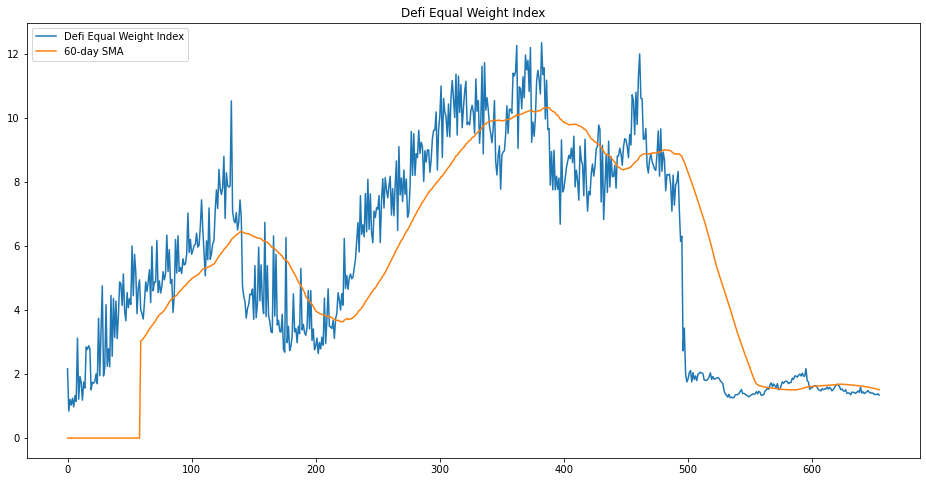

In [16]:
plt.plot(equal_weight_index.indexDefi.values,label="Defi Equal Weight Index")
plt.plot(sma60.indexDefi.values,label="60-day SMA")
plt.legend(loc="upper left")
plt.title('Defi Equal Weight Index')
plt.show()

## <font color='red'>Defi Clustering: 

#### Step 1: Compute mean returns and variance-covariance matrix of returns

meanReturns and covReturns store the outputs of the respective computations.

In [17]:
#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
print('Mean returns:\n', meanReturns)
covReturns = np.cov(arReturns, rowvar=False)
#set precision for printing results
np.set_printoptions(precision=5, suppress = True)
print('Size of Variance-Covariance matrix of returns:\n', covReturns.shape)
print('Variance-Covariance matrix of returns:\n', covReturns)

Mean returns:
 [-3.15938859e-07  9.20579516e-03  5.46706192e-02  6.86558085e-03
  1.83384649e-02  9.22158807e+01  6.49639114e-06  1.98275753e-02
  3.50557083e-03  2.16334895e-02  1.38938509e-04  4.27453194e-02
  7.17955848e-04  3.24469348e-02  6.20177616e-01  4.59301918e-02
  1.02810431e-02  3.63192023e-02  7.60096627e-03  1.91013577e-02
  1.67257475e-03  1.10186130e-01  5.04508160e-03  2.49413926e-03
  5.79445597e-02  3.84547437e-03  3.55824838e-03  1.36781712e-01
  4.05845951e-02  1.14661144e-02  1.29019372e-01  6.64889877e-03
  2.38529399e-02  7.45895457e-03  6.79729332e-03  1.54295137e-02
  9.46823665e-03  1.51119366e-02  3.35883674e-03  8.85659179e-04
  3.45374395e-02  1.25734528e-02]
Size of Variance-Covariance matrix of returns:
 (42, 42)
Variance-Covariance matrix of returns:
 [[ 0.      -0.       0.00006 ...  0.00001  0.00004  0.00001]
 [-0.       0.02146 -0.00259 ...  0.00157  0.01036  0.00215]
 [ 0.00006 -0.00259  0.3866  ... -0.00051 -0.00766  0.00039]
 ...
 [ 0.00001  0.00

#### Step 2: Prepare parameters for k-means clustering

Every Defi Ai  is characterized by its mean return and the variance-covariance vector of its returns with those of other assets  Aj . For i = j, it would indicate its own variance of returns. Thus the characteristic vector for asset  Ai  is given by  [μi,σi1,σi2,...σii,...σiN)] , where  μi  indicates the mean return of asset  Ai  and  σi1,σi2,...σii,...σiN  are the variance and covariance of its returns with other assets. It can be seen that  [σi1,σi2,...σii,...σiN]  is nothing but row  i  of the variance-covariance matrix  V  of  N  assets in the stock universe.  σii  which is the variance of the asset return, is the diagonal element of matrix  V  in row i.

The following Python code shows the gathering of parameters for each of the 43 assets in the Defi universe. The parameters are to be provided as inputs to the k-means clustering method.

In [18]:
#prepare asset parameters for k-means clustering
#reshape for concatenation
meanReturns = meanReturns.reshape(len(meanReturns),1)
assetParameters = np.concatenate([meanReturns, covReturns], axis = 1)
print('Size of the asset parameters for clustering:\n', assetParameters.shape)
print('Asset parameters for clustering:\n', assetParameters)

Size of the asset parameters for clustering:
 (42, 43)
Asset parameters for clustering:
 [[-0.       0.      -0.      ...  0.00001  0.00004  0.00001]
 [ 0.00921 -0.       0.02146 ...  0.00157  0.01036  0.00215]
 [ 0.05467  0.00006 -0.00259 ... -0.00051 -0.00766  0.00039]
 ...
 [ 0.00089  0.00001  0.00157 ...  0.00614  0.00333  0.00305]
 [ 0.03454  0.00004  0.01036 ...  0.00333  0.08449  0.00564]
 [ 0.01257  0.00001  0.00215 ...  0.00305  0.00564  0.02948]]


#### Step 3: Group the assets into clusters using k-means clustering where k =10, which is the portfolio size.

The Python code shows the invocation of the function KMeans from the scikit-learn library.

In [19]:
#kmeans clustering of assets using the characteristic vector of 
#mean return and variance-covariance vector of returns

clusters = 10

assetsCluster= KMeans(algorithm='auto',  max_iter=600, n_clusters=clusters, random_state=2)
print('Clustering of assets completed!') 
assetsCluster.fit(assetParameters)
centroids = assetsCluster.cluster_centers_
labels = assetsCluster.labels_

print('Centroids:\n', centroids)
print('Labels:\n', labels)

Clustering of assets completed!


c:\Users\Mouad Bouaida\Anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:1318: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Centroids:
 [[      0.01876       0.00002       0.00507       0.00576       0.00442
        0.0146      -18.07317       0.00003       0.00132       0.00235
        0.01337       0.00009       0.00825       0.00256       0.00533
        0.04679       0.00511       0.00255       0.00203       0.00566
        0.00505       0.00231       0.00428       0.00155       0.00243
        0.00414       0.00283       0.00178       0.00652       0.00959
        0.00244       0.00819       0.00189       0.00795       0.00383
        0.00223       0.0108        0.00185       0.00018       0.00226
        0.00266       0.02294       0.00278]
 [     92.21588       0.01726      -1.42153      -7.1314       -2.02915
      -19.93617 5526094.67352      -0.03325      -2.58519       1.92379
      -18.44876       0.03577      -6.36281      -2.74742      -8.38858
      -55.65677      -5.23157      -4.07615      -5.61733      -1.00558
        3.62384      -0.41623     -11.31044      51.49929      -1.93591
       

#### Step 4: Fix asset labels to points in each cluster

In [20]:
#fixing asset labels to cluster points

assetLabels = df.columns

clusters_dict = {}

print('Defi in each of the clusters:\n',)
assets = np.array(assetLabels)
for i in range(clusters):
    print('Cluster', i+1)
    clt  = np.where(labels == i)
    assetsCluster = assets[clt]
    print(assetsCluster)
    clusters_dict[i] = assetsCluster

Defi in each of the clusters:

Cluster 1
['Chainlink' 'Maker' 'NXM' 'SXP' 'Ren']
Cluster 2
['Luna Classic']
Cluster 3
['Dai' 'Wrapped Bitcoin' 'Uniswap' 'Frax' 'Tezos' 'Neutrino USD'
 'The Graph' 'Compound' '1inch Network' 'yearn.finance' 'Balancer' 'Serum'
 'SushiSwap' 'UMA' 'Reef']
Cluster 4
['DeFiChain']
Cluster 5
['Fantom']
Cluster 6
['Avalanche' 'PancakeSwap' 'Synthetix' 'THORChain' 'Curve DAO Token'
 'Basic Attention Token' 'Oasis Network' 'Reserve Rights' 'Secret']
Cluster 7
['Ankr']
Cluster 8
['Injective' 'Keep Network']
Cluster 9
['Loopring' 'Rocket Pool']
Cluster 10
['Aave' 'Kava' 'Gnosis' 'JUST' '0x']


# <font color='red'>Momentum Calculation
***
$$Momentum =  \displaystyle \frac{sma_{60}(y) - sma_{30}(y)}{y}\text{ , where }y = log(price)$$
***

In [21]:
def smaCrossMomentum(closes,slow_window=60,fast_window=30):
    returns = np.log(closes)
    slow_sma = returns.rolling(slow_window).mean()
    fast_sma = returns.rolling(fast_window).mean()
    return(((fast_sma-slow_sma)*100/returns).values)

In [22]:
momentums = df.copy(deep=True)
for defi in momentums.columns :
        momentums[defi] = smaCrossMomentum(df[defi])

In [23]:
momentums.dropna(inplace=True)
momentums.head()

,Dai,Wrapped Bitcoin,Avalanche,Uniswap,Chainlink,Luna Classic,Frax,Tezos,Aave,Maker,...,0x,Serum,SushiSwap,SXP,UMA,Secret,Injective,Reef,Ren,Keep Network
26/02/2021,4.445324,1.210322,16.757453,17.107183,8.289194,24.392142,10.587905,16.148262,9.408830,3.618136,...,107.013731,23.393784,20.394554,47.017521,14.340510,36.946682,15.749998,-12.012452,-140.332845,-17.101782
27/02/2021,7.297649,1.332237,16.680475,16.684087,8.219438,42.673815,45.274801,13.623345,9.164573,3.339085,...,347.879684,25.000186,19.787419,52.290021,16.127766,38.716669,15.829830,-12.334536,-276.086144,-14.866350
28/02/2021,8.712830,1.275035,17.678503,16.492914,7.681882,43.521506,-557.863284,14.357802,8.771335,3.320361,...,-2854.029893,27.111756,19.016585,47.781811,14.364684,40.792579,15.629820,-12.817036,410.502037,-14.572994
01/03/2021,12.486210,1.246071,17.768164,16.264372,7.395072,40.039667,-86.102200,12.097112,8.414935,3.154513,...,185.933244,27.302108,19.110738,51.257294,14.750665,45.113118,15.513031,-12.410344,-451.740793,-18.950575
02/03/2021,13.280259,1.163196,16.769179,15.029295,6.858029,35.875102,-77.700455,13.166355,7.958714,2.950344,...,254.585073,25.474816,17.268778,47.475617,14.588815,38.371636,14.558994,-12.900415,191.158136,-14.302905


<div class="alert alert-block alert-info">
In this part I will find for each week (Thursday precisely) the list of the 10 most efficient Defi in terms of momentum while respecting the rules described in Part A related to the representativeness of each cluster in the portfolio.
</div>

In [24]:
week_momentum = {}
bankruptcy_defi = {}

# Get 10 defi with highest momentum at the end of each week
for d in momentums.index:
    ind = list(df_returns.index).index(d)
    for defi in df_returns.columns:
        # Check if a Defi fall of more than 90% in its value
        if df_returns[defi].iloc[ind-6:ind+1].min() <= -0.9 and defi not in bankruptcy_defi:
            try : bankruptcy_defi[defi] += [d]
            except: bankruptcy_defi[defi] = [d]
    
    day_name = datetime.strptime(d, "%d/%m/%Y").strftime("%A")
    if day_name == 'Thursday':
        # Defi with a momentum > 50 are not selected
        k = momentums.loc[d][(abs(momentums.loc[d])<50)]
        kk = pd.DataFrame({'momentum':k})
        top_2_cluster = {}
        for i in range(len(clusters_dict)):
            top_2_cluster[i] = sorted([(kk.loc[v].momentum,v,i+1) for v in clusters_dict[i] if (v in kk.index) and (v not in bankruptcy_defi.keys())])[-2:]
        sorted_defi = sorted(list(itertools.chain.from_iterable(top_2_cluster.values())))[::-1][:10]
        sorted_defi = pd.DataFrame({'momentum':[kk.loc[d].momentum for d in [v[1] for v in sorted_defi]],
                                    'cluster' : [v[2] for v in sorted_defi]
                                   },
                                  index=[v[1] for v in sorted_defi])
        week_momentum[d] = sorted_defi

In [25]:
for d in bankruptcy_defi.keys():
    print(f'- The defi "{d}" is considred as a bankrupt project at : {bankruptcy_defi[d][0]}')

- The defi "Luna Classic" is considred as a bankrupt project at : 10/05/2022


In [26]:
# For each week buid a dataframe of the price data of the selected Defi :  
week_data_dict = {w:pd.DataFrame({d:df[d] for d in week_momentum[w].index}).iloc[:list(df.index).index(w)+1] for w in week_momentum.keys()}

#### Example : 
<div class="alert alert-block alert-warning">
<strong><em>Week : 20/05/2021
</div>

In [27]:
print('Defi selected the 20/05/2021')
week_momentum['20/05/2021']

Defi selected the 20/05/2021


,momentum,cluster
The Graph,35.596816,3
THORChain,11.640941,6
Ren,10.425526,1
PancakeSwap,10.368317,6
Serum,10.020217,3
Keep Network,6.891984,8
Injective,5.717968,8
DeFiChain,5.603812,4
NXM,4.882806,1
Rocket Pool,2.762836,9


In [28]:
print('Prices of Defi selected the 20/05/2021')
week_data_dict['20/05/2021']

Prices of Defi selected the 20/05/2021


,The Graph,THORChain,Ren,PancakeSwap,Serum,Keep Network,Injective,DeFiChain,NXM,Rocket Pool
29/12/2020,0.380357,1.036460,0.335007,0.536077,1.015460,0.209005,4.751879,1.316912,24.465493,5.421742
30/12/2020,0.372731,1.199241,0.302465,0.564923,1.078194,0.201156,4.311999,1.296751,23.911672,16.506291
31/12/2020,0.374873,1.699729,0.137077,0.601883,0.966790,0.198231,3.871555,1.114565,24.276547,2.320240
01/01/2021,0.350674,1.169678,0.321546,1.415069,1.039962,0.187890,4.065262,1.380840,26.671309,12.625908
02/01/2021,0.362392,2.002862,0.707198,0.661411,1.133318,0.209686,4.079060,1.333978,26.131789,2.252028
...,...,...,...,...,...,...,...,...,...,...
16/05/2021,1.315126,17.530446,0.773261,28.628611,7.872703,0.519603,16.231916,3.897199,130.847799,19.355694
17/05/2021,1.299053,16.799810,0.746412,29.198571,9.701702,0.478326,15.832070,3.793552,137.341126,21.123852
18/05/2021,1.193968,18.366675,0.994112,26.709145,9.201895,0.444263,14.459295,3.573952,125.641210,17.485454
19/05/2021,1.226397,20.341567,0.751245,26.995967,9.608845,0.446056,18.015733,3.493042,129.372209,20.618527


# <font color='red'>Constrained Portfolio Optimization

In [59]:
from defi.optimization import Optimization

ModuleNotFoundError: No module named 'defi.optimization'

In [58]:
defi.Optimization(week_data_dict['20/05/2021'],week_momentum).getOptimalAllocation()

AttributeError: module 'defi' has no attribute 'Optimization'

In [30]:
week_optimal_allocation = {
    w:Optimization(week_data_dict[w],week_momentum).getOptimalAllocation() 
    for w in week_data_dict.keys()
}

NameError: name 'Optimization' is not defined

#### Example : 
<div class="alert alert-block alert-warning">
<strong><em>Week : 20/05/2021
</div>

In [30]:
week_test = week_optimal_allocation['20/05/2021']
print('******************************************')
print('The Optimal Allocation for week 20/05/2021')
print('******************************************')
for i in range(10):
    print(f'- "{week_test[0][i]}" : {round(week_test[1][i]*100,2)}%')
print('******************************************')
print(f'The sum of weights is : {round(sum(week_test[1])*100,2)}%')
print('******************************************')    

******************************************
The Optimal Allocation for week 20/05/2021
******************************************
- "The Graph" : 14.22%
- "Basic Attention Token" : 6.5%
- "Ren" : 11.52%
- "Serum" : 13.65%
- "PancakeSwap" : 0.18%
- "THORChain" : 12.9%
- "DeFiChain" : 14.15%
- "SXP" : 10.12%
- "Rocket Pool" : 5.0%
- "Compound" : 11.74%
******************************************
The sum of weights is : 100.0%
******************************************


## <font color='red'>Backtesting and Evaluation

In [31]:
from defi.backtests import Backtesting

In [32]:
# The Backtesting starts at the First Thursday of the available time series
first_week = list(week_optimal_allocation.keys())[0]
first_week_ind = list(df_returns.index).index(first_week)
df_returns = df_returns.iloc[first_week_ind:]

In [33]:
bt = Backtesting(0.01)
portfolio_dict1,portfolio_value1 = bt.backtesting1(df_returns,week_optimal_allocation)
portfolio_dict2,portfolio_value2 = bt.backtesting2(df_returns,week_optimal_allocation,equal_weight_index)

Week 11/03/2021 momentum : [0.24999999999999412, 2.539461696482448e-14, 0.2999999999999592, 0.0, 0.04999999999999967, 3.3480163086352377e-16, 0.30000000000001226, 0.0500000000000104, 0.049999999999997075, 2.2499363483419188e-15]
**********************************************************************************
Week 18/03/2021 momentum : [9.870576578308032e-15, 0.0, 0.25000000000013756, 0.049999999999991315, 0.29999999999997273, 0.0, 0.3000000000000653, 0.049999999999987346, 0.04999999999998037, 0.0]
**********************************************************************************
Week 25/03/2021 momentum : [1.1293049828609014e-15, 0.049999999999929184, 0.1999999999998915, 1.9821817798248986e-13, 1.482668154917377e-14, 0.04999999999998792, 0.2999999999999751, 0.29999999999999166, 0.050000000000005124, 0.05000000000000501]
**********************************************************************************
Week 01/04/2021 momentum : [0.050000000000076816, 0.04999999999989732, 0.0, 0.04999

Week 30/12/2021 momentum : [0.14958936752636393, 0.12727809017862932, 0.0, 0.07272190982137075, 0.1504106324736356, 0.0499999999999984, 0.050000000000000405, 0.29999999999999993, 0.05000000000000286, 0.05000000000000014]
**********************************************************************************
Week 06/01/2022 momentum : [0.05000000000003974, 0.04999999999990454, 0.05000000000000505, 0.13691984264572468, 0.013080157354293586, 5.657534577934161e-15, 0.05000000000001192, 0.29999999999999455, 0.0500000000000059, 0.30000000000001426]
**********************************************************************************
Week 13/01/2022 momentum : [0.29999999999996724, 0.27075440090832753, 6.003853124053054e-15, 0.050000000000024296, 0.0, 0.049999999999998136, 0.029245599091721135, 0.14513240634202967, 0.05000000000002805, 0.10486759365792961]
**********************************************************************************
Week 20/01/2022 momentum : [0.05000000000001603, 0.300000000000

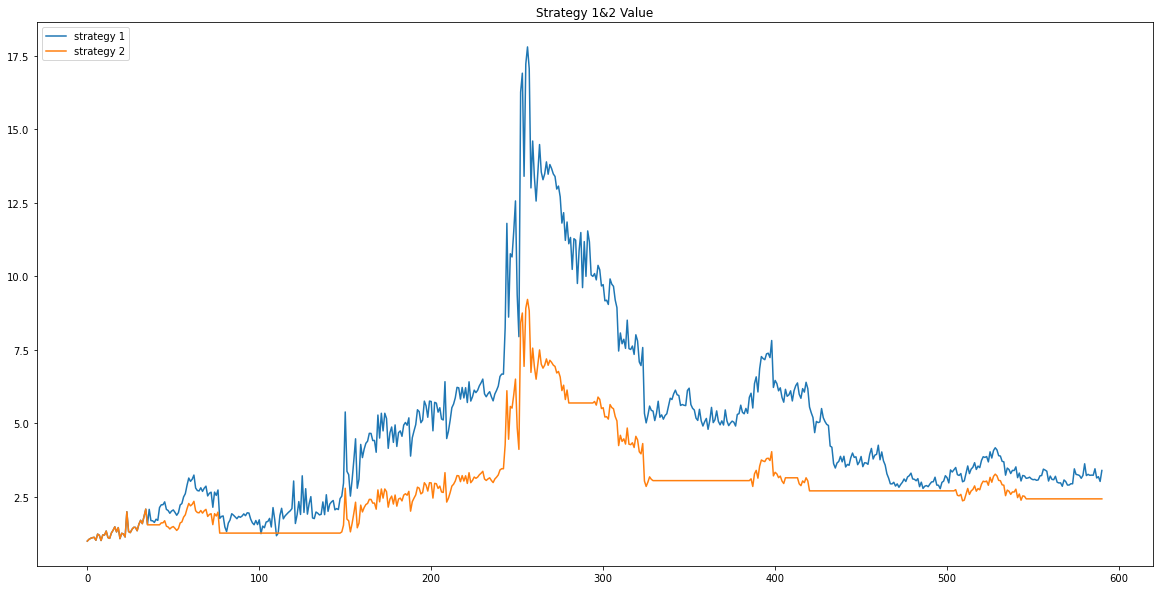

In [34]:
plt.figure(figsize=(20,10))
plt.plot(list(portfolio_value1.values()), label='strategy 1')
plt.plot(list(portfolio_value2.values()), label='strategy 2')
plt.legend(loc="upper left")
plt.title("Strategy 1&2 Value")
plt.show()

<div class="alert alert-block alert-success">
<strong><em>Evaluation and Comparison
</div>

In [35]:
from defi.evaluation import ann_estimated_sharpe_ratio, estimated_skewness, estimated_kurtosis, probabilistic_sharpe_ratio

In [36]:
df_porfolioValue = pd.DataFrame({'portfolioValue':portfolio_value1.values()},index=portfolio_value1.keys())
arPortfolioPrices = np.asarray(df_porfolioValue)
[rows, cols]= arPortfolioPrices.shape
returns_st1 = DefiReturnsComputing(arPortfolioPrices,rows,cols).reshape(1,-1)[0]

In [37]:
df_porfolioValue = pd.DataFrame({'portfolioValue':portfolio_value2.values()},index=portfolio_value1.keys())
arPortfolioPrices = np.asarray(df_porfolioValue)
[rows, cols]= arPortfolioPrices.shape
returns_st2 = DefiReturnsComputing(arPortfolioPrices,rows,cols).reshape(1,-1)[0]

C:\Users\Mouad Bouaida\Anaconda3\envs\py39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


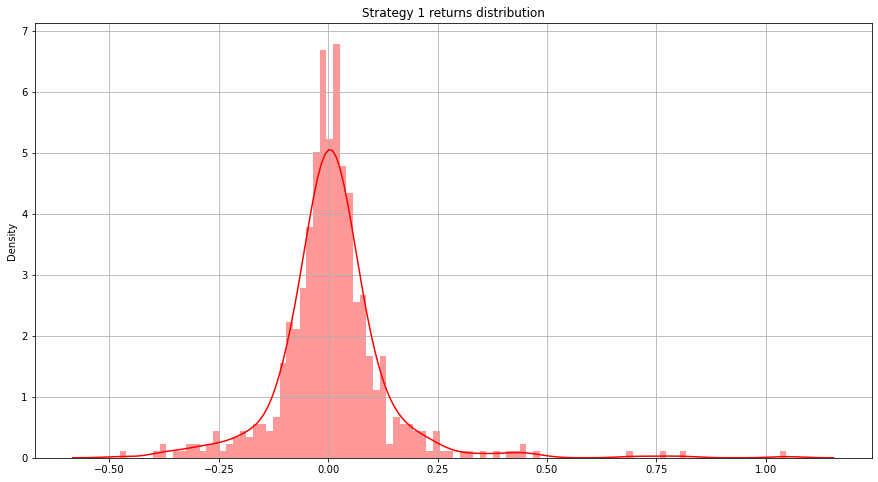

In [38]:
plt.figure(figsize=(15,8))
sns.distplot(pd.Series(returns_st1), hist=True, kde=True, color='red',  bins=100).set_title('Strategy 1 returns distribution')
plt.grid() 
plt.show()

C:\Users\Mouad Bouaida\Anaconda3\envs\py39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


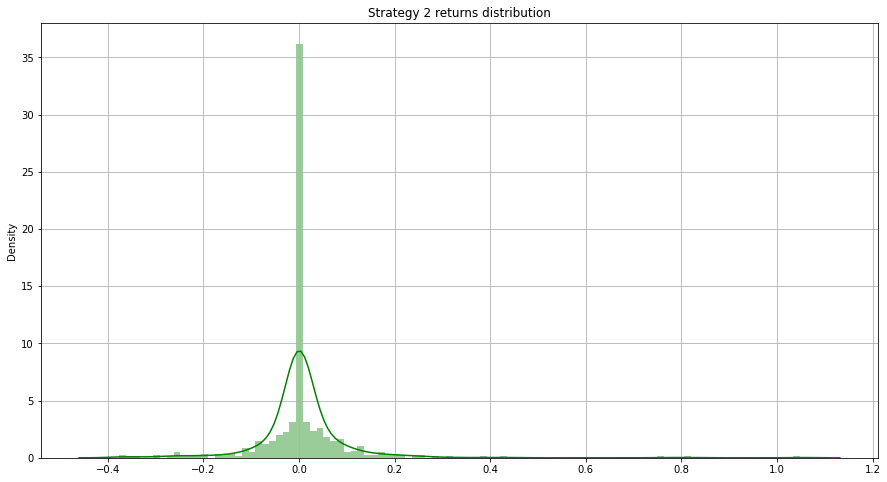

C:\Users\Mouad Bouaida\Anaconda3\envs\py39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


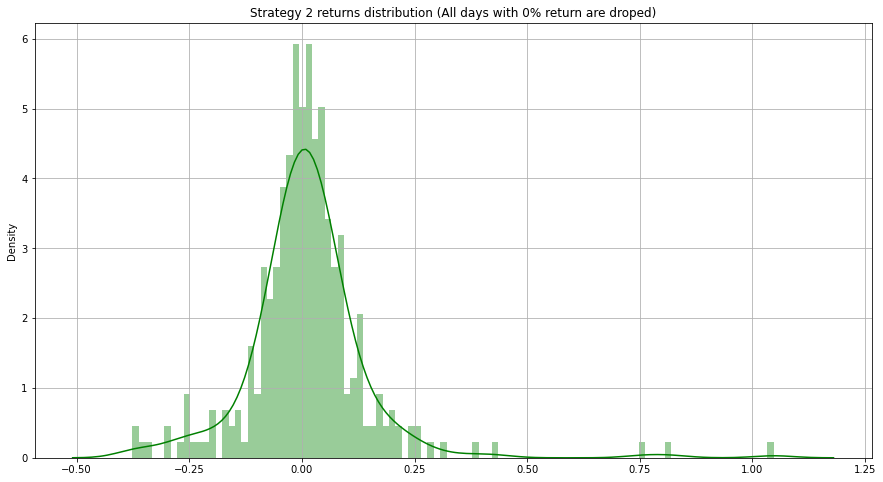

In [39]:
plt.figure(figsize=(15,8))
sns.distplot(pd.Series(returns_st2), hist=True, kde=True, color='green',  bins=100).set_title('Strategy 2 returns distribution')
plt.grid() 
plt.show()

plt.figure(figsize=(15,8))
sns.distplot(pd.Series(returns_st2[returns_st2!=0]), hist=True, kde=True, color='green',  bins=100).set_title('Strategy 2 returns distribution (All days with 0% return are droped)')
plt.grid() 
plt.show()

In [40]:
ann_sr_st1 = ann_estimated_sharpe_ratio(returns_st1)
ann_sr_st2 = ann_estimated_sharpe_ratio(returns_st2)
ann_sr_st2_0 = ann_estimated_sharpe_ratio(returns_st2[returns_st2!=0])

print('The annualized estimated sharpe ratio of strategy 1 : ', round(ann_sr_st1,3))
print('The annualized estimated sharpe ratio of strategy 2 : ', round(ann_sr_st2,3))
print('The annualized estimated sharpe ratio of strategy 2 (All 0% returns are droped) : ', round(ann_sr_st2_0,3))

The annualized estimated sharpe ratio of strategy 1 :  1.22
The annualized estimated sharpe ratio of strategy 2 :  0.965
The annualized estimated sharpe ratio of strategy 2 (All 0% returns are droped) :  1.337


In [41]:
skewness_st1 = estimated_skewness(returns_st1).values[0]
skewness_st2 = estimated_skewness(returns_st2).values[0]
skewness_st2_0 = estimated_skewness(returns_st2[returns_st2!=0]).values[0]

print('The estimated skewness of strategy 1 : ', round(skewness_st1,3))
print('The estimated skewness of strategy 2 : ', round(skewness_st2,3))
print('The estimated skewness of strategy 2 (All 0% returns are droped) : ', round(skewness_st2_0,3))

The estimated skewness of strategy 1 :  1.862
The estimated skewness of strategy 2 :  3.279
The estimated skewness of strategy 2 (All 0% returns are droped) :  2.262


In [42]:
kurtosis_st1 = estimated_kurtosis(returns_st1).values[0]
kurtosis_st2 = estimated_kurtosis(returns_st2).values[0]
kurtosis_st2_0 = estimated_kurtosis(returns_st2[returns_st2!=0]).values[0]

print('The estimated kurtosis of strategy 1 : ', round(kurtosis_st1,3))
print('The estimated kurtosis of strategy 2 : ', round(kurtosis_st2,3))
print('The estimated kurtosis of strategy 2 (All 0% returns are droped) : ', round(kurtosis_st2_0,3))

The estimated kurtosis of strategy 1 :  16.717
The estimated kurtosis of strategy 2 :  36.024
The estimated kurtosis of strategy 2 (All 0% returns are droped) :  18.562


In [43]:
psr_st1 = probabilistic_sharpe_ratio(returns_st1)
psr_st2 = probabilistic_sharpe_ratio(returns_st2)
psr_st2_0 = probabilistic_sharpe_ratio(returns_st2[returns_st2!=0])

print('PSR of strategy 1 :', round(psr_st1*100,2),'%')
print('PSR of strategy 2 :', round(psr_st2*100,2),'%')
print('PSR of strategy 2 (All 0% returns are droped) :', round(psr_st2_0*100,2),'%')

PSR of strategy 1 : 97.45 %
PSR of strategy 2 : 94.37 %
PSR of strategy 2 (All 0% returns are droped) : 94.29 %


<div class="alert alert-block alert-success">
<strong><em>Summary Table
</div>

In [44]:
pd.DataFrame({
    'Strategy 1':[str(round(np.mean(returns_st1*100),2))+'%',str(round(np.std(returns_st1*100),2))+'%',str(int(round((1+np.mean(returns_st1))**251-1,1)*100))+'%',round(ann_sr_st1,2),round(skewness_st1,2),round(kurtosis_st1,2),str(round(psr_st1*100,2))+'%'],
    'Strategy 2':[str(round(np.mean(returns_st2*100),2))+'%',str(round(np.std(returns_st2*100),2))+'%',str(int(round((1+np.mean(returns_st2))**251-1,1)*100))+'%',round(ann_sr_st2,2),round(skewness_st2,2),round(kurtosis_st2,2),str(round(psr_st2*100,2))+'%'],
    'Strategy 2 (0% returns filtred)':[str(round(np.mean(returns_st2[returns_st2!=0]*100),2))+'%',str(round(np.std(returns_st2[returns_st2!=0]*100),2))+'%',str(int(round((1+np.mean(returns_st2[returns_st2!=0]))**251-1,1)*100))+'%',round(ann_sr_st2_0,2),round(skewness_st2_0,2),round(kurtosis_st2_0,2),str(round(psr_st2_0*100,2))+'%']
},index=['Daily Excess Return','Daily Excess Return Std','Annualized Excess Return','Annualized Estimated Sharpe Ratio','Skewness','Kurtosis','Probabilistic Sharpe Ratio'])

,Strategy 1,Strategy 2,Strategy 2 (0% returns filtred)
Daily Excess Return,0.97%,0.6%,1.15%
Daily Excess Return Std,12.84%,10.05%,13.89%
Annualized Excess Return,1030%,350%,1670%
Annualized Estimated Sharpe Ratio,1.22,0.97,1.34
Skewness,1.86,3.28,2.26
Kurtosis,16.72,36.02,18.56
Probabilistic Sharpe Ratio,97.45%,94.37%,94.29%


## <font color='red'> Conclusion
<div class="alert alert-block alert-success">
<strong><em>
<p>The Table shows that all strategies delivred Sharpe ratios in a 0.97 to 1.34 range and a positive skewness. These solid Sharpe ratios were at least in part a compensation for the high volatility of Defi, taking ‘Momentum crash’ risk and the very eleveted tail risk (kurtosis much greater than 3).
    
<p>Even if we tried to diversify our portfolio by selecting Defi in different clusters. It seems that the Defi universe is very correlated and as a result of that all strategies suffer a sharp drawdown during market turning points.

<p>In addition to tail risk, there are other risks related to Momentum investing. For instance, Momentum can underperform during prolonged periods of range-bound price action and signals used to identify Momentum can also become ineffective.

<p>To reduce this risk we can for example use stop loss applied to our momentum strategies. Stop loss can in some cases improve the strategy’s risk adjusted performance. However, these improvements are not dramatic.So, there is no simple cost-less solution that would entirely eliminate momentum tail risk.

<p>By comparing these strategies we quickly realize that the first strategy is the best. It has the highest Sharpe ratio, positive skewness and the lowest kutrosis. Moreover, it has the highest Probabilistic Sharpe Ratio which means that strategy 1 has more chances that in the future its returns will have a sharpe ratio greater than 0.
</div>